# Exercise 3  -  Convolutional Neural Networks with Keras

Guadagnini Michele - 1230663

Lambertini Alessandro - 1242885

Pagano Alice - 1236916

Puppin Michele - 1227474

## Data generation

In [1]:
import random
import math 
import matplotlib.pyplot as plt

In [2]:
random.seed(12345)
# step: dx, DX (typical scale of dx), bias (bias of dx)
# P(dx) sim exp( - |dx-bias| / DX )
# lambda 
dx = lambda DX, bias: int( (math.log(random.random()) * DX) * 
                         2*(random.randint(0,1)-0.5) + bias)
for i in range(10):
    print(dx(50,5))

48
-4
12
-60
96
-1
33
29
56
-26


In [3]:
# pattern: amplitude a, number of bins z (steps)
def pattern(i,z,a):
    return int(a * math.sin((math.pi*i)/z))

[0, 48, 44, 56, -4, 92, 91, 124, 153, 209, 183, 214, 314, 236, 185, 136, 424, 442, 385, 502, 522, 524, 539, 438, 519, 457, 494, 658, 722, 821, 774, 687, 909, 931, 983, 977, 1058, 1099, 890, 839, 848, 903, 937, 907, 985, 1080, 1116, 1025, 1036, 975, 845, 893, 902, 727, 818, 909, 911, 972, 999, 1027] 0
[1027, 1046, 996, 1104, 1042, 1203, 1231, 1328, 1269, 1256, 1202, 1149, 1247, 1412, 1574, 1678, 1906, 1922, 1824, 1702, 1611, 1383, 1317, 1236, 1116, 1049, 1134, 1247, 1241, 1292, 1226, 1326, 1264, 1177, 1345, 1468, 1444, 1449, 1466, 1445, 1476, 1442, 1632, 1630, 1654, 1602, 1453, 1411, 1519, 1496, 1503, 1532, 1533, 1547, 1514, 1660, 1660, 1679, 1731, 1735] 1
[1735, 1745, 1659, 1672, 1698, 1715, 1748, 1870, 1798, 1729, 1719, 1744, 1770, 1743, 1677, 1664, 1631, 1567, 1614, 1531, 1602, 1584, 1403, 1413, 1407, 1234, 1189, 1267, 1341, 1551, 1611, 1608, 1517, 1324, 1220, 1134, 1062, 1083, 1086, 1144, 1234, 1360, 1419, 1548, 1516, 1539, 1559, 1564, 1583, 1565, 1479, 1479, 1393, 1375, 1338, 1273,

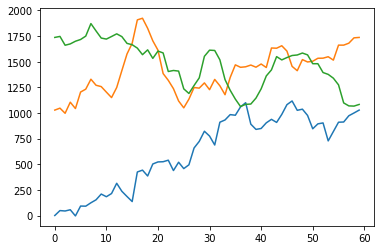

In [4]:
random.seed(12345)
# Amplitude
A = 500 
# Length
Z = 12 

# sample length 
L = 60 
# number of data sample
N = 10000
# step parameters
DX = 50
bias = 5

y = [0] * N
x = [[0] * L for i in range(N)]

for i in range(N):
    if i>0: 
        x[i][0] = x[i-1][-1]
        
    for j in range(1,L):
        x[i][j] = x[i][j-1] + dx(DX,bias)
        
    y[i] = i%3
    if y[i]>0:
        j0 = random.randint(0,L-1-Z)
        sign = 3-2*y[i]
        for j in range(Z):
            x[i][j0+j] += sign*pattern(j,Z,A)
            
for i in range(3):
    print(x[i],y[i])

plt.plot(x[0])
plt.plot(x[1])
plt.plot(x[2])

plt.show()

In [5]:
# create folder DATA
import subprocess, csv
# linux
subprocess.run(["mkdir","DATA"])

CompletedProcess(args=['mkdir', 'DATA'], returncode=1)

In [6]:
# write on csv file
str0 = f'ts_L{L}_Z{Z}_A{A}_DX{DX}_bias{bias}_N{N}.csv'
print(str0)

fname = 'DATA/x_'+str0

with open(fname, mode='w') as myfile:
    writer = csv.writer(myfile, delimiter=',')
    for i in range(N):
        writer.writerow(x[i])
        
fname = 'DATA/y_'+str0

with open(fname, mode='w') as myfile:
    writer = csv.writer(myfile, delimiter=',')
    writer.writerows(map(lambda yy: [yy],y))    

ts_L60_Z12_A500_DX50_bias5_N10000.csv


## Import dataset

In [7]:
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten 
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D

Using TensorFlow backend.


10000


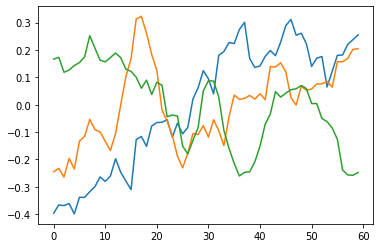

N_train = 8000    N_val = 2000    L = 60     n_class = 3


In [8]:
str0 = str0 #'ts_L60_Z12_A500_DX50_bias5_N10000.csv'

fnamex = 'DATA/x_'+str0
fnamey = 'DATA/y_'+str0

x = np.loadtxt(fnamex, delimiter=',', dtype=float)
N = len(x)
print(N)

xm = x.mean(axis=1)

for i in range(N):
    x[i] = (x[i]-xm[i]) 

# Divide for the maximum absolute value so the rescaled data lies within the interval [-1,1]
xmaximum = np.abs(x.max())
#x /= 100    # lazy version of dividing by variance
x /= xmaximum

plt.plot(x[0])
plt.plot(x[1])
plt.plot(x[2])
plt.show()

categ = np.loadtxt(fnamey, delimiter=',', dtype=int)
n_class = 3

y = np.zeros((N,n_class))
for i in range(N):
    y[i][categ[i]] = 1.

perc_train = 0.8

N_train = int(N*perc_train)
x_train = x[:N_train]
y_train = y[:N_train]
x_val = x[N_train:]
y_val = y[N_train:]
N_val = len(y_val)

L = len(x[0])
print('N_train =',N_train,'   N_val =', N_val, '   L =', L,'    n_class =', n_class)

 ### Data reshaping

In [9]:
x_train = x_train.reshape(x_train.shape[0],L,1)
x_val = x_val.reshape(x_val.shape[0],L,1)
input_shape = (L,1)

## 1 - Different CNN architectures

In [10]:
from keras import initializers, regularizers

In [11]:
ini = keras.initializers.glorot_normal(seed=12345) #CHANGE #keras.initializers.RandomNormal(mean=0,stddev=0.05,seed=12345)


NCONV = 3

model = Sequential(name='Diff_process')

# Baiesi's CNN 
if NCONV==1: 
    model.add(Conv1D(filters=5, kernel_size=11, kernel_initializer=ini,
                     activation='relu', input_shape=input_shape))
    model.add(AveragePooling1D(5))
    model.add(Conv1D(filters=5, kernel_size=7, activation='relu'))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(0.2))

# CNN with only one convolutional layer and with two dense layers 1
if NCONV==2: 
    model.add(Conv1D(filters=5, kernel_size=11, 
                    kernel_initializer=ini,
                    activation='relu',
                    input_shape=input_shape))
    model.add(AveragePooling1D(5))
    model.add(Flatten())
    model.add(Dense(8, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.2))
    
# CNN with only one convolutional layer and with two dense layers 2
if NCONV==3: 
    model.add(Conv1D(filters=5, kernel_size=15, 
                    kernel_initializer=ini,
                    activation='relu',
                    input_shape=input_shape))
    model.add(MaxPooling1D(5))
    model.add(Flatten())
    model.add(Dense(9, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(8, activation='relu'))

# CNN with two convolutional layers and  with three dense layers
if NCONV==4: #0.90600
    model.add(Conv1D(filters=5, kernel_size=14, 
                    kernel_initializer=ini,
                    activation='relu',
                    input_shape=input_shape))
    model.add(MaxPooling1D(5))
    model.add(Conv1D(filters=5, kernel_size=7, activation='relu'))
    model.add(Flatten())
    model.add(Dense(9, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(7, activation='relu'))
    model.add(Dense(9, activation='relu'))
    
model.add(Dense(n_class, activation='softmax'))

print(model.summary())

from keras import optimizers 
#opt = optimizers.SGD(lr=0.1, momentum=0.9, nesterov=True, decay=1e-6)
#opt = optimizers.RMSprop()
opt = optimizers.Adam(learning_rate=0.009) 
#opt = optimizers.Nadam(learning_rate=0.009)

# model: categorical
model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=opt,metrics=['accuracy'])

Model: "Diff_process"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 46, 5)             80        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 9, 5)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 45)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 414       
_________________________________________________________________
dropout_1 (Dropout)          (None, 9)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 80        
_________________________________________________________________
dense_3 (Dense)              (None, 3)                

### Fitting the CNN

In [12]:
batch_size = 250
epochs = 300

fit = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val,y_val),
                verbose=2, shuffle = True)


Train on 8000 samples, validate on 2000 samples
Epoch 1/300
 - 3s - loss: 1.0501 - accuracy: 0.4485 - val_loss: 0.9722 - val_accuracy: 0.5995
Epoch 2/300
 - 1s - loss: 0.8606 - accuracy: 0.6531 - val_loss: 0.7385 - val_accuracy: 0.7300
Epoch 3/300
 - 1s - loss: 0.6944 - accuracy: 0.7166 - val_loss: 0.6111 - val_accuracy: 0.7745
Epoch 4/300
 - 1s - loss: 0.6103 - accuracy: 0.7590 - val_loss: 0.5485 - val_accuracy: 0.7985
Epoch 5/300
 - 1s - loss: 0.5571 - accuracy: 0.7818 - val_loss: 0.4911 - val_accuracy: 0.8335
Epoch 6/300
 - 0s - loss: 0.5141 - accuracy: 0.8035 - val_loss: 0.4559 - val_accuracy: 0.8465
Epoch 7/300
 - 1s - loss: 0.4721 - accuracy: 0.8266 - val_loss: 0.4366 - val_accuracy: 0.8505
Epoch 8/300
 - 1s - loss: 0.4477 - accuracy: 0.8369 - val_loss: 0.3985 - val_accuracy: 0.8700
Epoch 9/300
 - 1s - loss: 0.4259 - accuracy: 0.8496 - val_loss: 0.3854 - val_accuracy: 0.8760
Epoch 10/300
 - 0s - loss: 0.4131 - accuracy: 0.8555 - val_loss: 0.3704 - val_accuracy: 0.8800
Epoch 11/30

Epoch 87/300
 - 0s - loss: 0.2773 - accuracy: 0.9054 - val_loss: 0.3019 - val_accuracy: 0.8885
Epoch 88/300
 - 0s - loss: 0.2904 - accuracy: 0.8959 - val_loss: 0.3106 - val_accuracy: 0.8885
Epoch 89/300
 - 0s - loss: 0.2871 - accuracy: 0.9019 - val_loss: 0.2984 - val_accuracy: 0.8935
Epoch 90/300
 - 0s - loss: 0.2882 - accuracy: 0.9006 - val_loss: 0.3104 - val_accuracy: 0.8905
Epoch 91/300
 - 0s - loss: 0.2805 - accuracy: 0.9016 - val_loss: 0.2970 - val_accuracy: 0.8960
Epoch 92/300
 - 0s - loss: 0.2757 - accuracy: 0.9031 - val_loss: 0.2968 - val_accuracy: 0.8965
Epoch 93/300
 - 0s - loss: 0.2838 - accuracy: 0.9021 - val_loss: 0.3025 - val_accuracy: 0.8945
Epoch 94/300
 - 0s - loss: 0.2775 - accuracy: 0.9026 - val_loss: 0.2989 - val_accuracy: 0.8915
Epoch 95/300
 - 0s - loss: 0.2802 - accuracy: 0.9028 - val_loss: 0.3086 - val_accuracy: 0.8920
Epoch 96/300
 - 0s - loss: 0.2775 - accuracy: 0.9043 - val_loss: 0.2970 - val_accuracy: 0.8960
Epoch 97/300
 - 0s - loss: 0.2723 - accuracy: 0.90

Epoch 173/300
 - 0s - loss: 0.2605 - accuracy: 0.9111 - val_loss: 0.2998 - val_accuracy: 0.8950
Epoch 174/300
 - 0s - loss: 0.2680 - accuracy: 0.9049 - val_loss: 0.3042 - val_accuracy: 0.8975
Epoch 175/300
 - 0s - loss: 0.2609 - accuracy: 0.9097 - val_loss: 0.3000 - val_accuracy: 0.9000
Epoch 176/300
 - 0s - loss: 0.2764 - accuracy: 0.9057 - val_loss: 0.2950 - val_accuracy: 0.8985
Epoch 177/300
 - 0s - loss: 0.2639 - accuracy: 0.9082 - val_loss: 0.3024 - val_accuracy: 0.8955
Epoch 178/300
 - 0s - loss: 0.2684 - accuracy: 0.9045 - val_loss: 0.2951 - val_accuracy: 0.9025
Epoch 179/300
 - 0s - loss: 0.2763 - accuracy: 0.9044 - val_loss: 0.3045 - val_accuracy: 0.8970
Epoch 180/300
 - 0s - loss: 0.2678 - accuracy: 0.9095 - val_loss: 0.2947 - val_accuracy: 0.8985
Epoch 181/300
 - 0s - loss: 0.2640 - accuracy: 0.9089 - val_loss: 0.2950 - val_accuracy: 0.9000
Epoch 182/300
 - 0s - loss: 0.2683 - accuracy: 0.9078 - val_loss: 0.2972 - val_accuracy: 0.9010
Epoch 183/300
 - 0s - loss: 0.2623 - acc

Epoch 259/300
 - 0s - loss: 0.2648 - accuracy: 0.9062 - val_loss: 0.2982 - val_accuracy: 0.9015
Epoch 260/300
 - 0s - loss: 0.2558 - accuracy: 0.9125 - val_loss: 0.3000 - val_accuracy: 0.9015
Epoch 261/300
 - 0s - loss: 0.2585 - accuracy: 0.9125 - val_loss: 0.3104 - val_accuracy: 0.8980
Epoch 262/300
 - 0s - loss: 0.2618 - accuracy: 0.9086 - val_loss: 0.2941 - val_accuracy: 0.9045
Epoch 263/300
 - 0s - loss: 0.2645 - accuracy: 0.9070 - val_loss: 0.3092 - val_accuracy: 0.8890
Epoch 264/300
 - 0s - loss: 0.2617 - accuracy: 0.9080 - val_loss: 0.3107 - val_accuracy: 0.8945
Epoch 265/300
 - 0s - loss: 0.2646 - accuracy: 0.9085 - val_loss: 0.3113 - val_accuracy: 0.8900
Epoch 266/300
 - 0s - loss: 0.2586 - accuracy: 0.9112 - val_loss: 0.3008 - val_accuracy: 0.9020
Epoch 267/300
 - 0s - loss: 0.2635 - accuracy: 0.9093 - val_loss: 0.3005 - val_accuracy: 0.9015
Epoch 268/300
 - 0s - loss: 0.2608 - accuracy: 0.9100 - val_loss: 0.2990 - val_accuracy: 0.8955
Epoch 269/300
 - 0s - loss: 0.2640 - acc

In [13]:
print('Max accuracy:', np.array(fit.history['val_accuracy']).max())

Max accuracy: 0.906499981880188


| Conf. | Accuracy |
|------|------|
| NCONV = 1 | 0.887 |
| NCONV = 2 | 0.863 |
| NCONV = 3 | 0.906 |
| NCONV = 4 | 0.904 |

The best accuracy is obtained with NCONV = 3. 

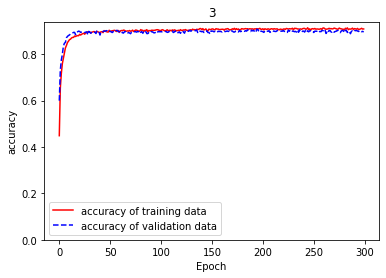

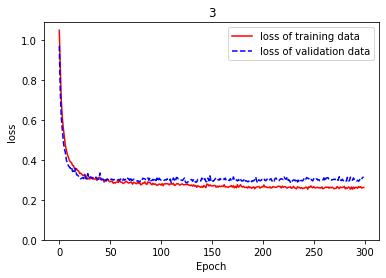

In [14]:
for obs in ('accuracy','loss'):
    plt.figure(figsize=(6,4))
    plt.plot(fit.history[obs], 'r', label=obs+' of training data')
    plt.plot(fit.history['val_'+obs], 'b--', label=obs+' of validation data')
    plt.title(NCONV)
    plt.xlabel('Epoch')
    plt.ylabel(obs)
    plt.legend()
    plt.ylim(0)
    plt.show()

# 2 - Confusion matrix

In [15]:
import seaborn 
from sklearn import metrics

y_pred = model.predict_classes(x_val)

n_labels = 3

y_val1 = []

for i in range(len(y_val)):
    for j in range(n_labels):
        if y_val[i][j]==1:
            y_val1.append(j)   
                       
confusion_matrics = metrics.confusion_matrix(y_val1, y_pred)

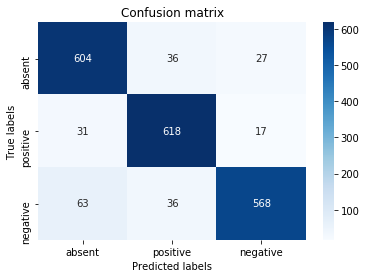

In [16]:
ticks = ["absent", "positive", "negative"]
seaborn.heatmap(confusion_matrics, annot=True, cmap="Blues",
                fmt="d", xticklabels=ticks, yticklabels=ticks)
plt.title("Confusion matrix")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()

# 3 - Regularization 

In [17]:
ini = keras.initializers.glorot_normal(seed=12345) 

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers

def compile_model(lambda_val = 0.1): 
    #reg = keras.regularizers.l1(lambda_val)
    reg = keras.regularizers.l2(lambda_val)
    #reg = keras.regularizers.l1_l2(lambda_val)
    # create the model
    model = Sequential(name='Diff_process')
    model.add(Conv1D(filters=5, kernel_size=15, kernel_initializer=ini, kernel_regularizer=reg, 
                     activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(5))
    model.add(Conv1D(filters=5, kernel_size=7, activation='relu'))
    model.add(Flatten())
    model.add(Dense(9, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(8, activation='relu'))
    
    model.add(Dense(n_class, activation='softmax'))
    opt = optimizers.Adam(learning_rate=0.009) 
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=opt,metrics=['accuracy'])
    return model

## Grid search with different values of $\lambda$

In [18]:
# call Keras scikit wrapper
model_gridsearch = KerasClassifier(build_fn=compile_model, 
                        epochs=100, 
                        batch_size=100, 
                        verbose=0)

# list of allowed optional arguments for the optimizer, see `compile_model()`
lambda_val = [0.,0.0001,0.001,0.005]

# define parameter dictionary
param_grid = dict(lambda_val=lambda_val)
# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=2, cv=4)
grid_result = grid.fit(x_train,y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.894875 using {'lambda_val': 0.0001}
0.893750 (0.011909) with: {'lambda_val': 0.0}
0.894875 (0.007461) with: {'lambda_val': 0.0001}
0.891125 (0.007660) with: {'lambda_val': 0.001}
0.873500 (0.015330) with: {'lambda_val': 0.005}


| Conf. | $\lambda$ | Accuracy |
|------|------|------|
| l1 |     0.0001    | 0.891 |
| l2 | 0.0001  | 0.901 |
| l1_l2 |  0.0   | 0.887 |


The best accuracy is obtained with $l2$ regularization. 

In [19]:
model = compile_model(grid_result.best_params_['lambda_val'])

In [20]:
batch_size = 250
epochs = 300

fit = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val,y_val),
                verbose=2, shuffle = True)

Train on 8000 samples, validate on 2000 samples
Epoch 1/300
 - 3s - loss: 1.0596 - accuracy: 0.4297 - val_loss: 0.9713 - val_accuracy: 0.5995
Epoch 2/300
 - 1s - loss: 0.8719 - accuracy: 0.6419 - val_loss: 0.7696 - val_accuracy: 0.7275
Epoch 3/300
 - 1s - loss: 0.6792 - accuracy: 0.7333 - val_loss: 0.5347 - val_accuracy: 0.8110
Epoch 4/300
 - 0s - loss: 0.5174 - accuracy: 0.8037 - val_loss: 0.4044 - val_accuracy: 0.8635
Epoch 5/300
 - 0s - loss: 0.4218 - accuracy: 0.8583 - val_loss: 0.3650 - val_accuracy: 0.8780
Epoch 6/300
 - 1s - loss: 0.3927 - accuracy: 0.8769 - val_loss: 0.3503 - val_accuracy: 0.8805
Epoch 7/300
 - 1s - loss: 0.3656 - accuracy: 0.8849 - val_loss: 0.3352 - val_accuracy: 0.8870
Epoch 8/300
 - 0s - loss: 0.3517 - accuracy: 0.8888 - val_loss: 0.3316 - val_accuracy: 0.8870
Epoch 9/300
 - 1s - loss: 0.3504 - accuracy: 0.8832 - val_loss: 0.3341 - val_accuracy: 0.8905
Epoch 10/300
 - 0s - loss: 0.3443 - accuracy: 0.8916 - val_loss: 0.3309 - val_accuracy: 0.8895
Epoch 11/30

Epoch 87/300
 - 1s - loss: 0.2640 - accuracy: 0.9085 - val_loss: 0.3342 - val_accuracy: 0.8820
Epoch 88/300
 - 0s - loss: 0.2662 - accuracy: 0.9080 - val_loss: 0.3080 - val_accuracy: 0.8870
Epoch 89/300
 - 1s - loss: 0.2626 - accuracy: 0.9082 - val_loss: 0.3072 - val_accuracy: 0.8940
Epoch 90/300
 - 0s - loss: 0.2623 - accuracy: 0.9089 - val_loss: 0.3280 - val_accuracy: 0.8840
Epoch 91/300
 - 0s - loss: 0.2638 - accuracy: 0.9104 - val_loss: 0.3141 - val_accuracy: 0.8940
Epoch 92/300
 - 0s - loss: 0.2704 - accuracy: 0.9100 - val_loss: 0.3028 - val_accuracy: 0.8915
Epoch 93/300
 - 0s - loss: 0.2661 - accuracy: 0.9082 - val_loss: 0.3276 - val_accuracy: 0.8855
Epoch 94/300
 - 1s - loss: 0.2660 - accuracy: 0.9081 - val_loss: 0.2955 - val_accuracy: 0.9000
Epoch 95/300
 - 0s - loss: 0.2560 - accuracy: 0.9114 - val_loss: 0.3073 - val_accuracy: 0.8890
Epoch 96/300
 - 0s - loss: 0.2608 - accuracy: 0.9114 - val_loss: 0.3060 - val_accuracy: 0.8950
Epoch 97/300
 - 0s - loss: 0.2641 - accuracy: 0.90

Epoch 173/300
 - 0s - loss: 0.2387 - accuracy: 0.9201 - val_loss: 0.3047 - val_accuracy: 0.8965
Epoch 174/300
 - 0s - loss: 0.2451 - accuracy: 0.9158 - val_loss: 0.3245 - val_accuracy: 0.8820
Epoch 175/300
 - 0s - loss: 0.2391 - accuracy: 0.9178 - val_loss: 0.2813 - val_accuracy: 0.9005
Epoch 176/300
 - 0s - loss: 0.2463 - accuracy: 0.9155 - val_loss: 0.2889 - val_accuracy: 0.9035
Epoch 177/300
 - 0s - loss: 0.2458 - accuracy: 0.9162 - val_loss: 0.2852 - val_accuracy: 0.9000
Epoch 178/300
 - 0s - loss: 0.2411 - accuracy: 0.9175 - val_loss: 0.2991 - val_accuracy: 0.9020
Epoch 179/300
 - 1s - loss: 0.2420 - accuracy: 0.9186 - val_loss: 0.2967 - val_accuracy: 0.9020
Epoch 180/300
 - 0s - loss: 0.2481 - accuracy: 0.9176 - val_loss: 0.3646 - val_accuracy: 0.8745
Epoch 181/300
 - 0s - loss: 0.2501 - accuracy: 0.9149 - val_loss: 0.2920 - val_accuracy: 0.9010
Epoch 182/300
 - 0s - loss: 0.2413 - accuracy: 0.9191 - val_loss: 0.2987 - val_accuracy: 0.8995
Epoch 183/300
 - 0s - loss: 0.2419 - acc

Epoch 259/300
 - 0s - loss: 0.2386 - accuracy: 0.9189 - val_loss: 0.3086 - val_accuracy: 0.8970
Epoch 260/300
 - 0s - loss: 0.2457 - accuracy: 0.9151 - val_loss: 0.3226 - val_accuracy: 0.8935
Epoch 261/300
 - 0s - loss: 0.2454 - accuracy: 0.9147 - val_loss: 0.3183 - val_accuracy: 0.8920
Epoch 262/300
 - 0s - loss: 0.2418 - accuracy: 0.9178 - val_loss: 0.3000 - val_accuracy: 0.8960
Epoch 263/300
 - 0s - loss: 0.2478 - accuracy: 0.9166 - val_loss: 0.3026 - val_accuracy: 0.8990
Epoch 264/300
 - 0s - loss: 0.2504 - accuracy: 0.9144 - val_loss: 0.3223 - val_accuracy: 0.8920
Epoch 265/300
 - 0s - loss: 0.2421 - accuracy: 0.9194 - val_loss: 0.2904 - val_accuracy: 0.9015
Epoch 266/300
 - 0s - loss: 0.2385 - accuracy: 0.9201 - val_loss: 0.2871 - val_accuracy: 0.9070
Epoch 267/300
 - 0s - loss: 0.2420 - accuracy: 0.9189 - val_loss: 0.3093 - val_accuracy: 0.8960
Epoch 268/300
 - 1s - loss: 0.2396 - accuracy: 0.9205 - val_loss: 0.2947 - val_accuracy: 0.8960
Epoch 269/300
 - 1s - loss: 0.2431 - acc

In [21]:
print('Max accuracy:', np.array(fit.history['val_accuracy']).max())

Max accuracy: 0.9070000052452087


w0T= [[[ 0.02174073  0.21251722  1.730533    0.2169954  -0.1380491
   -0.13306172 -0.40361798 -0.7293084  -0.729789   -1.001303
   -0.44076085 -0.12248866 -0.45853412  0.32240734  1.764878  ]]

 [[ 0.1632348  -0.49407855 -1.2330416  -0.18722671 -0.0120357
    0.5464605   0.14131798  0.39739338  0.89925224  0.5723147
    0.52000123  0.6575799   0.31630522 -0.04710506 -2.0999315 ]]

 [[-1.7684828  -0.20741671  0.49253902  0.38971657  0.6371362
    0.46832547  0.6852047   0.7591858   0.27866623  0.2793509
    0.00873151 -0.07859287 -1.9288974   0.1899154  -0.03774635]]

 [[ 0.01549343  0.04143174  0.1904362   0.26272535 -0.31760913
    0.5509333   2.6276577  -2.3199668  -0.39221704 -0.1688734
   -0.17621222 -0.489947   -0.16776207  0.03742385  0.5862154 ]]

 [[ 1.815293    0.12927258 -0.5601466   0.06005817 -0.6327862
   -0.97816026 -0.8258895   0.06312498 -0.25761595 -0.48924124
   -0.31245902  0.04003216  1.4583604   0.24493355  0.1746825 ]]]
w01= [-0.57308847 -0.5300981  -0.6630219  -0

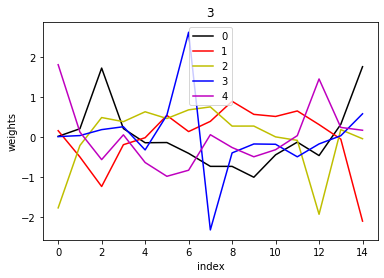

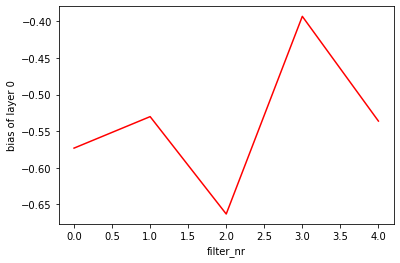

In [22]:
# Weights of the filters of the first layer
c = ['k','r','y','b','m']
def plot_w(w):
    plt.figure(figsize=(6,4))
    for i in range(len(w)):
        plt.plot(w[i][0], c[i], label=str(i))
    plt.title(NCONV)
    plt.xlabel('index')
    plt.ylabel('weights')
    plt.legend()
    plt.show()
    
w0 = model.layers[0].get_weights()[0]
w01 = model.layers[0].get_weights()[1]
w0T = w0.T
print('w0T=',w0T)
print('w01=',w01)
print(len(w0))
print(len(w0T))
plot_w(w0T)

plt.plot(w01, 'r')
plt.xlabel('filter_nr')
plt.ylabel('bias of layer 0')
plt.show()

w0T= [[[ 0.9180261   1.8002555  -2.2379618  -0.73700356 -1.0364556
    0.10070094  2.0755875 ]
  [-0.32037184  0.4487864  -0.43554333  0.48767632 -0.6163447
    0.62921065 -0.05029932]
  [-0.63987094 -0.7605673  -0.46327364  0.11118077  0.2726669
   -0.24574289 -0.946291  ]
  [-1.9647845  -0.13030474 -1.3041052   0.0494407  -0.11265432
   -2.7434263  -1.39648   ]
  [ 1.8021615   0.09982951 -0.09347164  1.8361455  -1.0855279
    0.6062292   1.3907207 ]]

 [[ 0.34132028  0.8404975   0.41858673  0.94484186  0.02282275
    2.137483    2.504594  ]
  [ 0.39247623  0.8594572  -0.69342273  0.47411776  0.39076725
   -0.18181126 -1.6406894 ]
  [ 1.0088615  -0.8505163  -0.8803027  -0.7866261   0.750476
   -1.0184803   0.1059724 ]
  [ 0.0638243  -0.70903796 -0.9617048  -0.5203805  -1.2913476
   -1.44938     0.07025035]
  [-0.79826146  0.47583017  0.375241   -0.51715213 -0.6391994
    0.6458955   0.28996032]]

 [[ 0.11825341  0.12442179 -0.3021619   0.22527051 -0.35792965
    0.01213892 -0.06552062

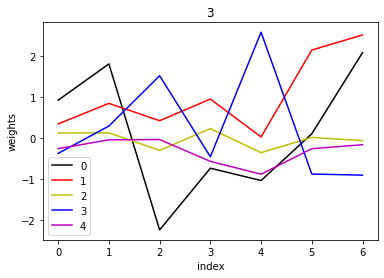

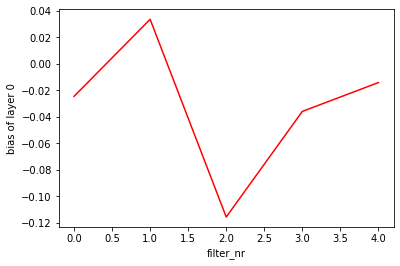

In [23]:
# Weights of the filters of the second layer
c = ['k','r','y','b','m']
def plot_w(w):
    plt.figure(figsize=(6,4))
    for i in range(len(w)):
        plt.plot(w[i][0], c[i], label=str(i))
    plt.title(NCONV)
    plt.xlabel('index')
    plt.ylabel('weights')
    plt.legend()
    plt.show()
    
w0 = model.layers[2].get_weights()[0]
w01 = model.layers[2].get_weights()[1]
w0T = w0.T
print('w0T=',w0T)
print('w01=',w01)
print(len(w0))
print(len(w0T))
plot_w(w0T)

plt.plot(w01, 'r')
plt.xlabel('filter_nr')
plt.ylabel('bias of layer 0')
plt.show()

# 4 - Reducing signal-to-noise ratio

In [24]:
random.seed(12345)
dx = lambda DX, bias: int( (math.log(random.random()) * DX) * 
                         2*(random.randint(0,1)-0.5) + bias)

def pattern(i,z,a):
    return int(a * math.sin((math.pi*i)/z))

random.seed(12345)
A = 200
Z = 12 
L = 60 
N = 10000
DX = 50
bias = 5

y = [0] * N
x = [[0] * L for i in range(N)]

for i in range(N):
    if i>0: 
        x[i][0] = x[i-1][-1]
        
    for j in range(1,L):
        x[i][j] = x[i][j-1] + dx(DX,bias)
        
    y[i] = i%3
    if y[i]>0:
        j0 = random.randint(0,L-1-Z)
        sign = 3-2*y[i]
        for j in range(Z):
            x[i][j0+j] += sign*pattern(j,Z,A)

subprocess.run(["mkdir","DATA"])

CompletedProcess(args=['mkdir', 'DATA'], returncode=1)

In [25]:
# write on csv file
str0 = f'ts_L{L}_Z{Z}_A{A}_DX{DX}_bias{bias}_N{N}.csv'
print(str0)

fname = 'DATA/x_'+str0

with open(fname, mode='w') as myfile:
    writer = csv.writer(myfile, delimiter=',')
    for i in range(N):
        writer.writerow(x[i])
        
fname = 'DATA/y_'+str0

with open(fname, mode='w') as myfile:
    writer = csv.writer(myfile, delimiter=',')
    writer.writerows(map(lambda yy: [yy],y))    

ts_L60_Z12_A200_DX50_bias5_N10000.csv


In [26]:
str0 = str0 #'ts_L60_Z12_A500_DX50_bias5_N10000.csv'

fnamex = 'DATA/x_'+str0
fnamey = 'DATA/y_'+str0

x = np.loadtxt(fnamex, delimiter=',', dtype=float)
N = len(x)
print(N)

xm = x.mean(axis=1)

for i in range(N):
    x[i] = (x[i]-xm[i]) 

xmaximum = np.abs(x.max())
x /= xmaximum

categ = np.loadtxt(fnamey, delimiter=',', dtype=int)
n_class = 3

y = np.zeros((N,n_class))
for i in range(N):
    y[i][categ[i]] = 1.

perc_train = 0.8

N_train = int(N*perc_train)
x_train = x[:N_train]
y_train = y[:N_train]
x_val = x[N_train:]
y_val = y[N_train:]
N_val = len(y_val)

L = len(x[0])
print('N_train =',N_train,'   N_val =', N_val, '   L =', L,'    n_class =', n_class)

10000
N_train = 8000    N_val = 2000    L = 60     n_class = 3


In [27]:
x_train = x_train.reshape(x_train.shape[0],L,1)
x_val = x_val.reshape(x_val.shape[0],L,1)
input_shape = (L,1)

In [28]:
ini = keras.initializers.glorot_normal(seed=12345) 

model = Sequential(name='Diff_process')
    
# CNN with only one convolutional layer and with two dense layers 2
model.add(Conv1D(filters=5, kernel_size=15, 
                kernel_initializer=ini,
                activation='relu',
                input_shape=input_shape))
model.add(MaxPooling1D(5))
model.add(Flatten())
model.add(Dense(9, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(8, activation='relu'))
    
model.add(Dense(n_class, activation='softmax'))

print(model.summary())

opt = optimizers.Adam(learning_rate=0.009) 

model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=opt,metrics=['accuracy'])

Model: "Diff_process"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 46, 5)             80        
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 9, 5)              0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 45)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 9)                 414       
_________________________________________________________________
dropout_4 (Dropout)          (None, 9)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 80        
_________________________________________________________________
dense_12 (Dense)             (None, 3)                

In [29]:
batch_size = 250
epochs = 300

fit = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val,y_val),
                verbose=2, shuffle = True)


Train on 8000 samples, validate on 2000 samples
Epoch 1/300
 - 3s - loss: 1.0985 - accuracy: 0.3441 - val_loss: 1.0970 - val_accuracy: 0.3340
Epoch 2/300
 - 1s - loss: 1.0930 - accuracy: 0.3683 - val_loss: 1.0846 - val_accuracy: 0.4025
Epoch 3/300
 - 1s - loss: 1.0847 - accuracy: 0.3842 - val_loss: 1.0802 - val_accuracy: 0.4040
Epoch 4/300
 - 1s - loss: 1.0794 - accuracy: 0.4019 - val_loss: 1.0744 - val_accuracy: 0.4130
Epoch 5/300
 - 1s - loss: 1.0715 - accuracy: 0.4144 - val_loss: 1.0713 - val_accuracy: 0.4170
Epoch 6/300
 - 1s - loss: 1.0709 - accuracy: 0.4221 - val_loss: 1.0687 - val_accuracy: 0.4270
Epoch 7/300
 - 0s - loss: 1.0670 - accuracy: 0.4289 - val_loss: 1.0675 - val_accuracy: 0.4260
Epoch 8/300
 - 1s - loss: 1.0610 - accuracy: 0.4326 - val_loss: 1.0626 - val_accuracy: 0.4395
Epoch 9/300
 - 0s - loss: 1.0599 - accuracy: 0.4367 - val_loss: 1.0648 - val_accuracy: 0.4250
Epoch 10/300
 - 1s - loss: 1.0578 - accuracy: 0.4453 - val_loss: 1.0598 - val_accuracy: 0.4420
Epoch 11/30

Epoch 87/300
 - 0s - loss: 1.0245 - accuracy: 0.4851 - val_loss: 1.0515 - val_accuracy: 0.4570
Epoch 88/300
 - 0s - loss: 1.0226 - accuracy: 0.4821 - val_loss: 1.0573 - val_accuracy: 0.4445
Epoch 89/300
 - 0s - loss: 1.0242 - accuracy: 0.4757 - val_loss: 1.0521 - val_accuracy: 0.4585
Epoch 90/300
 - 0s - loss: 1.0274 - accuracy: 0.4766 - val_loss: 1.0559 - val_accuracy: 0.4600
Epoch 91/300
 - 0s - loss: 1.0249 - accuracy: 0.4801 - val_loss: 1.0579 - val_accuracy: 0.4455
Epoch 92/300
 - 0s - loss: 1.0226 - accuracy: 0.4882 - val_loss: 1.0566 - val_accuracy: 0.4455
Epoch 93/300
 - 0s - loss: 1.0221 - accuracy: 0.4825 - val_loss: 1.0549 - val_accuracy: 0.4515
Epoch 94/300
 - 0s - loss: 1.0281 - accuracy: 0.4805 - val_loss: 1.0550 - val_accuracy: 0.4510
Epoch 95/300
 - 0s - loss: 1.0220 - accuracy: 0.4848 - val_loss: 1.0550 - val_accuracy: 0.4520
Epoch 96/300
 - 0s - loss: 1.0215 - accuracy: 0.4852 - val_loss: 1.0565 - val_accuracy: 0.4485
Epoch 97/300
 - 0s - loss: 1.0213 - accuracy: 0.48

Epoch 173/300
 - 0s - loss: 1.0182 - accuracy: 0.4879 - val_loss: 1.0559 - val_accuracy: 0.4565
Epoch 174/300
 - 0s - loss: 1.0216 - accuracy: 0.4740 - val_loss: 1.0589 - val_accuracy: 0.4490
Epoch 175/300
 - 0s - loss: 1.0191 - accuracy: 0.4824 - val_loss: 1.0594 - val_accuracy: 0.4520
Epoch 176/300
 - 0s - loss: 1.0219 - accuracy: 0.4831 - val_loss: 1.0570 - val_accuracy: 0.4550
Epoch 177/300
 - 0s - loss: 1.0186 - accuracy: 0.4834 - val_loss: 1.0622 - val_accuracy: 0.4515
Epoch 178/300
 - 0s - loss: 1.0198 - accuracy: 0.4841 - val_loss: 1.0549 - val_accuracy: 0.4560
Epoch 179/300
 - 0s - loss: 1.0203 - accuracy: 0.4902 - val_loss: 1.0571 - val_accuracy: 0.4555
Epoch 180/300
 - 0s - loss: 1.0207 - accuracy: 0.4785 - val_loss: 1.0560 - val_accuracy: 0.4580
Epoch 181/300
 - 0s - loss: 1.0181 - accuracy: 0.4830 - val_loss: 1.0598 - val_accuracy: 0.4545
Epoch 182/300
 - 0s - loss: 1.0187 - accuracy: 0.4863 - val_loss: 1.0616 - val_accuracy: 0.4515
Epoch 183/300
 - 0s - loss: 1.0168 - acc

Epoch 259/300
 - 0s - loss: 1.0187 - accuracy: 0.4874 - val_loss: 1.0541 - val_accuracy: 0.4560
Epoch 260/300
 - 0s - loss: 1.0151 - accuracy: 0.4879 - val_loss: 1.0576 - val_accuracy: 0.4550
Epoch 261/300
 - 0s - loss: 1.0169 - accuracy: 0.4771 - val_loss: 1.0599 - val_accuracy: 0.4495
Epoch 262/300
 - 0s - loss: 1.0169 - accuracy: 0.4820 - val_loss: 1.0584 - val_accuracy: 0.4555
Epoch 263/300
 - 0s - loss: 1.0133 - accuracy: 0.4870 - val_loss: 1.0565 - val_accuracy: 0.4465
Epoch 264/300
 - 0s - loss: 1.0181 - accuracy: 0.4824 - val_loss: 1.0544 - val_accuracy: 0.4635
Epoch 265/300
 - 1s - loss: 1.0168 - accuracy: 0.4850 - val_loss: 1.0586 - val_accuracy: 0.4465
Epoch 266/300
 - 0s - loss: 1.0146 - accuracy: 0.4881 - val_loss: 1.0588 - val_accuracy: 0.4510
Epoch 267/300
 - 0s - loss: 1.0147 - accuracy: 0.4940 - val_loss: 1.0577 - val_accuracy: 0.4595
Epoch 268/300
 - 0s - loss: 1.0183 - accuracy: 0.4861 - val_loss: 1.0586 - val_accuracy: 0.4550
Epoch 269/300
 - 0s - loss: 1.0161 - acc

In [30]:
print('Max accuracy:', np.array(fit.history['val_accuracy']).max())

Max accuracy: 0.47099998593330383


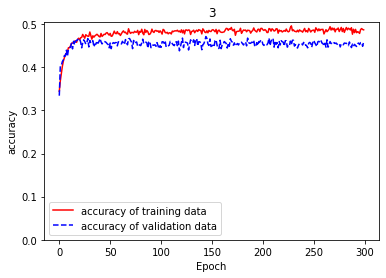

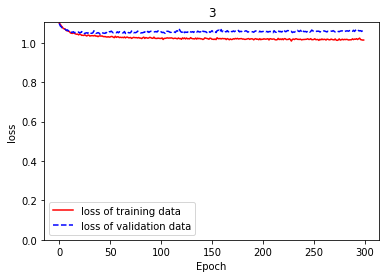

In [31]:
for obs in ('accuracy','loss'):
    plt.figure(figsize=(6,4))
    plt.plot(fit.history[obs], 'r', label=obs+' of training data')
    plt.plot(fit.history['val_'+obs], 'b--', label=obs+' of validation data')
    plt.title(NCONV)
    plt.xlabel('Epoch')
    plt.ylabel(obs)
    plt.legend()
    plt.ylim(0)
    plt.show()

In [32]:
import seaborn 
from sklearn import metrics

y_pred = model.predict_classes(x_val)

n_labels = 3

y_val1 = []

for i in range(len(y_val)):
    for j in range(n_labels):
        if y_val[i][j]==1:
            y_val1.append(j)   
            
confusion_matrics = metrics.confusion_matrix(y_val1, y_pred)

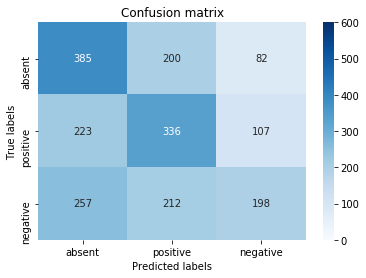

In [33]:
ticks = ["absent", "positive", "negative"]
seaborn.heatmap(confusion_matrics, annot=True, vmin=0, vmax=600, cmap="Blues",
                fmt="d", xticklabels=ticks, yticklabels=ticks)
plt.title("Confusion matrix")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()